# <center> Neural Networks and Deep Learning (CSCI 5922)</center>
# <center> Spring 2020 </center>

**Name:** Nicholas Renninger

## Goal

The goal of this assignment is to introduce neural networks in terms of ideas you are already familiar with:  linear regression and classification

## Dataset

You are given a dataset with 2 input variables ($x_1$, $x_2$) and an output variable ($y$).

In [25]:
from matplotlib import pyplot as plt
import numpy as np
import os
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

# Load data
data = np.loadtxt(os.path.join('data', 'assign1_data.txt'),  delimiter=',')
predictors = data[:, :2]
targets = data[:, 2].reshape((-1, 1))
target_class_labels = data[:, 3].reshape((-1, 1))

numExamples = len(predictors)

## Part 1

Write a program to find the exact least squares solution to $y = w_1 x_1 + w_2 x_2 + b$ for the above dataset, using the normal equation.

Complete the following function below and use it to answer questions (A) and (B). 

**Note:** Please do not change the interface of the given function.

In [26]:
def least_squares(X, y):
    """
    Finds the Least Squares solution
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of output value 'y' (size : no of examples X 1)
    
    Returns
    -------
    w : solution array
    """
    
    # as is done in MATLAB, since we are really solving:
    #      (X_b^T * X_b) * w = X_b^T * y
    # for the computation of the moore-penrose inverse, we can help speed up 
    # stabilize calculation by directly solving the matrix equation instead 
    # relying on expensive inverse calculations
    X_b = getFeaturesWithBias(X)
    w = np.linalg.solve(X_b.T @ X_b, X_b.T) @ y
    
    return w

def getFeaturesWithBias(X):
    """
    Returns the Feature Matrix with a column of ones added for the bias term
    
    need to add a column of ones to the feature matrix to account for the
    bias term 'b' in our linear model:
            y = w_1 * x_1 + w_2 * x_2 + b
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    
    Returns
    -------
    X_b : NumPy array of features with bias column added 
          (size : no of examples X (features + 1))
          
    Examples
    --------
    X = [[0.3 0.5]
         [0.5 0.4]
         [0.7 1.5]]
         
         
    X_b = [[0.3 0.5 1.0]
           [0.5 0.4 1.0]
           [0.7 1.5 1.0]]
    """
    
    numFeatures, _ = np.shape(X)
    biasFeatureMat = np.ones(shape=(numFeatures, 1))
    X_b = np.concatenate((X, biasFeatureMat), axis=1)
    
    return X_b

def computePointwiseQuadraticLoss(y, y_hat):
    """
    Computes the quadratic loss for each target-target_est pair
    
    linear regression is typically formulated assuming an MSE loss
    
    Parameters
    ----------
    y : Numpy array of output value 'y' (size : no of examples X 1)
    y_hat : Numpy array of estimated output value (size : no of examples X 1)
    
    Returns
    -------
    loss : Numpy array of losses for each pair of y-y_hat
           (size : no of examples X 1)
    """
    
    N = len(y)
    
    # here, accounting for the 1 degree of freedom in a linear model with one
    # predictor variable for the computation of Mean-square-error (MSE))
    loss = 1 / (N - 2) * np.square(y - y_hat)
    
    return loss

### (A) Report the values of $w_1$, $w_2$, and $b$.

In [27]:
weights = least_squares(predictors, targets)
regressed_targets = getFeaturesWithBias(predictors) @ weights

print('w_1:', weights[0])
print('w_2:', weights[1])
print('b:', weights[2])

w_1: [-2.0442426]
w_2: [3.99686017]
b: [-0.92429081]


$w_1 = -2.04424$ 

$w_2 = 3.99686$

$b = -0.92429$

Now, we can examine the fitting performance of our linear regression model. Below, we see how the regressed target values compare to the observed target values for each predictor. They match quite well, as is expected on the test set.

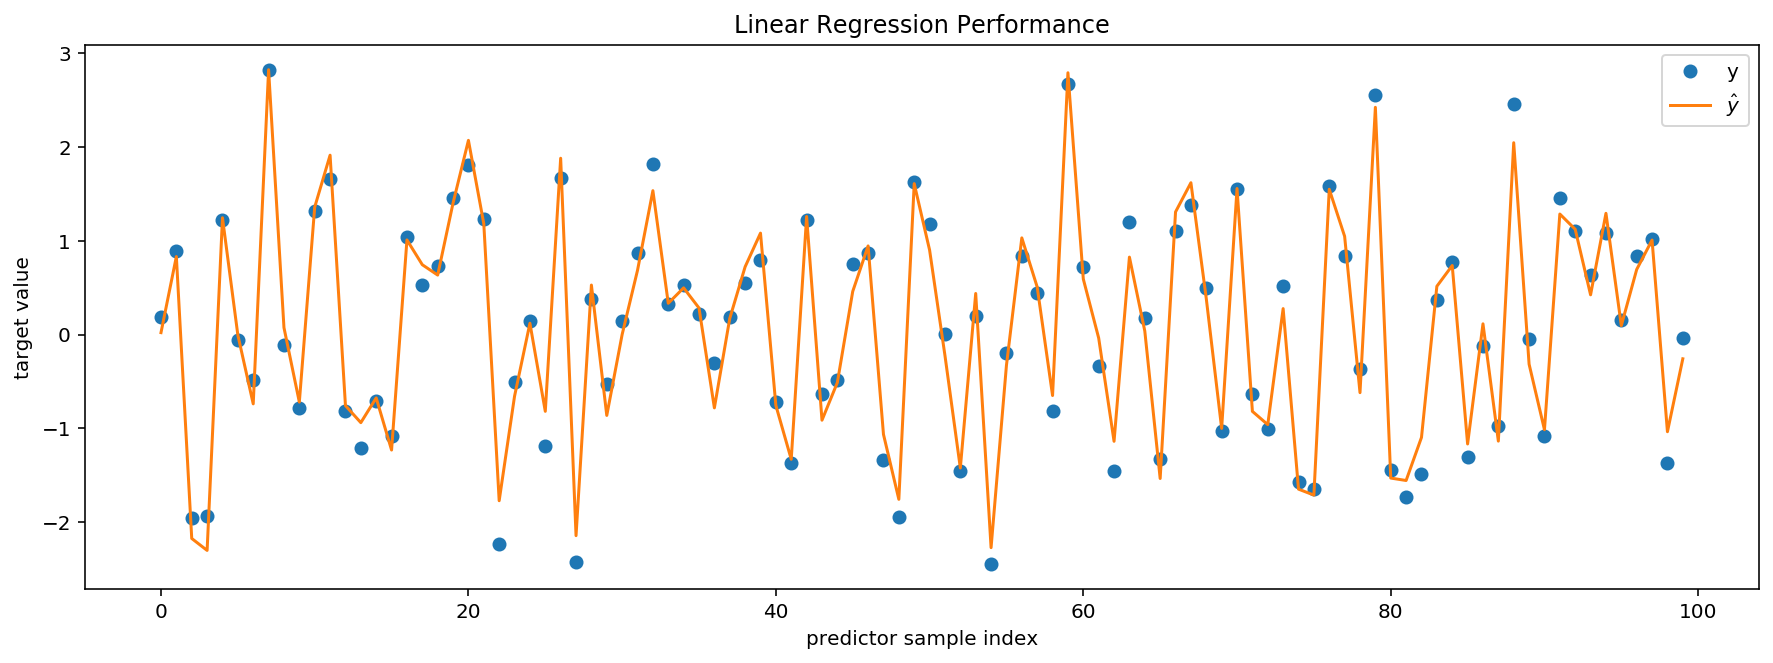

In [28]:
def plot_regression_performance(predictor_indices, targets, regressed_targets):

    plt.figure()

    # make it wide to see the timeseries more easily
    plt.rcParams['figure.figsize'] = [15, 5]
    plt.plot(predictor_indices, targets, 'o', label=r'y')
    plt.plot(predictor_indices, regressed_targets, '-', label=r'$\hat{y}$')

    plt.legend()
    plt.title('Linear Regression Performance')
    plt.xlabel('predictor sample index');
    plt.ylabel('target value');

predictor_indices = range(0, numExamples)
plot_regression_performance(predictor_indices, targets, regressed_targets)

Here we investigate the loss term as a function of each predictor. It is as expected, with the loss generally being quite low, except for some outliers that don't fit the linear model well.

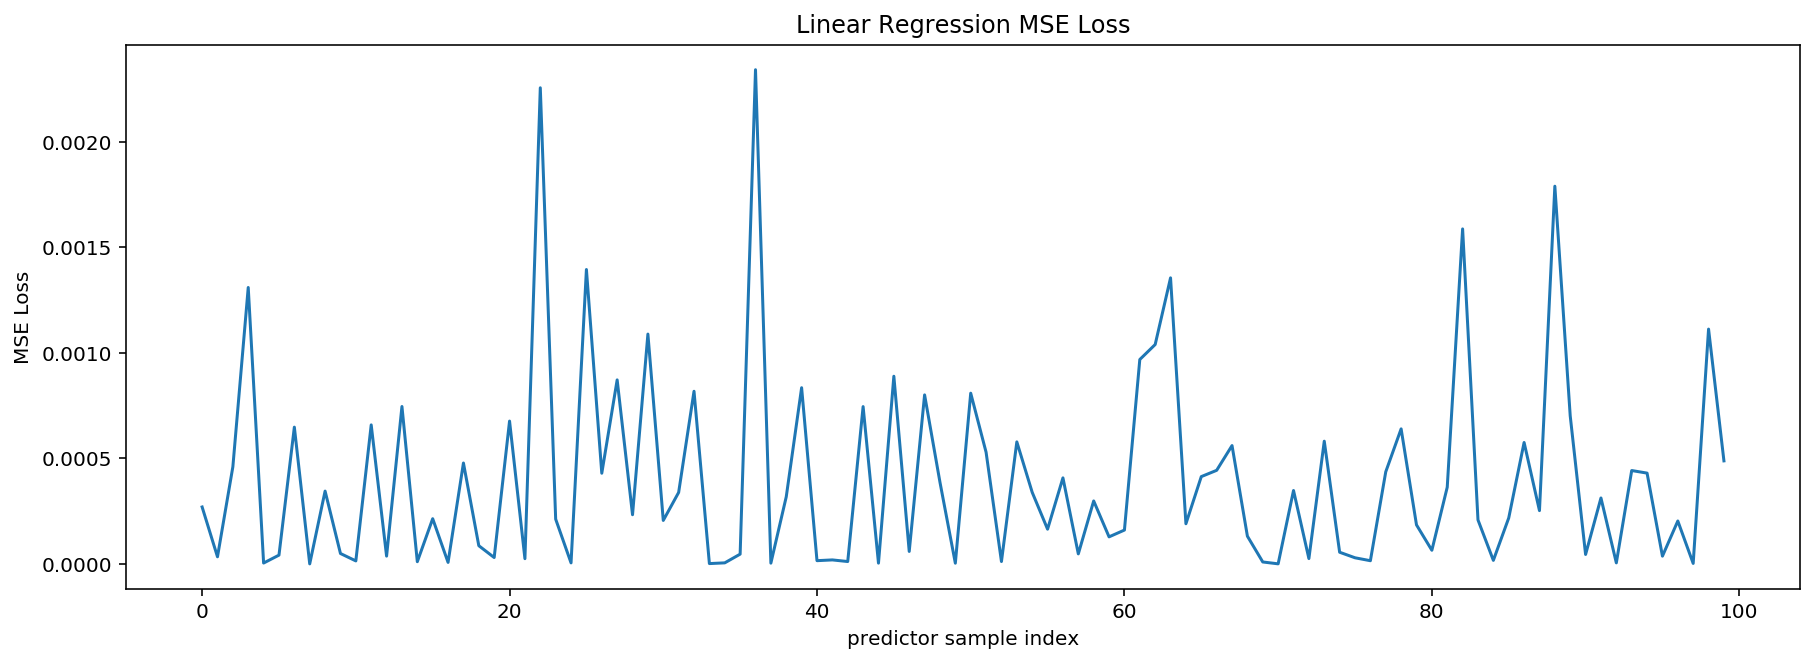

In [62]:
def plot_loss(indices, lossData, xlabel, ylabel, **kwargs):
    
    plt.figure()
    
    # make it wide to see the timeseries more easily
    plt.rcParams['figure.figsize'] = [15, 5]
    
    for loss in lossData:
        plt.plot(indices, loss, '-')
    
    if 'title' in kwargs:
        plt.title(kwargs['title'])
    else:
        plt.title('Linear Regression MSE Loss')
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);
    
    if 'legendStrings' in kwargs:
        plt.legend(kwargs['legendStrings'])

loss = computePointwiseQuadraticLoss(targets, regressed_targets)
plot_loss(predictor_indices, [loss],
          xlabel='predictor sample index',
          ylabel='MSE Loss')

### (B) What function or method did you use to find the least-squares solution?

The least-squares solution is the result of optimizing:

\begin{equation*}
X \cdot \mathbf{w} = Y
\end{equation*}

where $\mathbf{\hat{w}}$ is the estimated weight vector, $Y$ is the target vector, and $\hat{Y}$ is the regressed target vector. We optimize our quadratic loss to find $\mathbf{\hat{w}}$:
\begin{align*}
\mathbf{\hat{w}} &= \mathbf{w} \mid (Y - \hat{Y})^T \cdot (Y - \hat{Y}) = 0 \\
                 &= \mathbf{w} \mid (Y - X \cdot \mathbf{w})^T \cdot (Y - X \cdot \mathbf{w}) = 0 \\
\end{align*}


The solution, assuming a linearly independent columns of $X$, can be robustly computed with the Moore-Penrose psuedoinverse of the predictor matrix $X$:

\begin{equation*}
X^{+}=\left(X^{T} X\right)^{-1} X^T
\end{equation*}

Thus, the loss-minimizing weight vector $\mathbf{\hat{w}}$ is computed as:
\begin{equation*}
\mathbf{\hat{w}} = X^{+} Y
\end{equation*}


## Part 2
*Implement linear regression of y on X via first-order optimization of the least-squares objective. Write a program that determines the coefficients {w1,w2,b}. Implement stochastic gradient descent, batch gradient descent, and mini-batch gradient descent. You will need to experiment with updating rules, step sizes (i.e. learning rates), stopping criteria, etc. Experiment to find settings that lead to solutions with the fewest number of sweeps through the data.*


Complete the following functions below and use them to answer questions (A), (B) and (C). You may find the shuffle function from scikit-learn useful. 

Use the following hyperparameters:

`Learning rates = [0.001, 0.05, 0.01, 0.05, 0.1, 0.3]`

`MaxIter = [10, 50, 100, 500, 1000, 5000, 10000, 25000, 50000]`

**Note:** Please do not change the interface of the given functions.

In [30]:
from sklearn.utils import shuffle

def compute_MSE_loss(y, y_hat):
    """
    Computes the total MSE loss for across all y-y_hat pairs
    
    linear regression is typically formulated assuming an MSE loss
    
    Parameters
    ----------
    y : Numpy array of output value 'y' (size : no of examples X 1)
    y_hat : Numpy array of estimated output value (size : no of examples X 1)
    
    Returns
    -------
    loss : scalar MSE loss over the whole data set
    """
    
    N = len(y)

    # here, accounting for the 1 degree of freedom in a linear model with one
    # predictor variable for the computation of Mean-square-error (MSE))
    residuals = (y - y_hat) ** 2
    loss = 1 / (N - 2) * np.sum(residuals)
    
    return loss

def get_batch_indices(curr_idx, batch_size, num_batches, batch_remainder):
    """
    Calculates the mini-batch indices in the larger data set
    
    Parameters
    ----------
    curr_idx : the batch index
    batch_size : the number of examples in each batch
    num_batches : the number of batches to split the total epoch into
    batch_remainder : the number of batches that don't fit into num_batches
                      groups of size batch_size in the full dataset
    
    Returns
    ----------
    a list of indices into the main data set to use in the current batch
    """
    
    startIdx = curr_idx * batch_size
    endIdx = (curr_idx + 1) * batch_size
    
    # may need to make the last batch extra big to handle spillover
    makeLastBatchBigger = False
    if batch_remainder != 0:
        makeLastBatchBigger = True
        
    atLastBatch = curr_idx == (num_batches - 1)
    if atLastBatch and makeLastBatchBigger:
        endIdx += batch_remainder

    batchIndices = range(startIdx, endIdx)
    
    return batchIndices

def least_squares_loss_gradient(X, y, w):
    """
    Calculates the gradient w.r.t. w of the LLS quadratic loss function
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    w : array of coefficients from the previous iteration
    
    Returns
    -------
    scalar gradient of the loss w.r.t. w at the given X, y
    """

    return 2 * X.T @ (X @ w - y)

def online_epoch(X, y, w, alpha, *batch_size):
    """
    One epoch of stochastic gradient descent (i.e. one sweep of the dataset).
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    w : array of coefficients from the previous iteration
    alpha : Learning rate
    batch_size : number of examples in a batch (unused, just for interface)
    
    Returns
    -------
    Coefficients of the model (after updating), loss after epoch
    """
    
    return mini_batch_update(X, y, w, alpha, batch_size=1)

def batch_update(X, y, w, alpha, *batch_size):
    """
    One iteration of full-batch gradient descent.
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    w : array of coefficients from the previous iteration
    alpha : Learning rate
    batch_size : number of examples in a batch (unused, just for interface)
    
    Returns
    -------
    Coefficients of the model (after updating), loss after epoch
    """
    
    N = len(y)
    return mini_batch_update(X, y, w, alpha, batch_size=N)

def mini_batch_update(X, y, w, alpha, batch_size):
    """
    One epoch of mini-batch SGD over the entire dataset (i.e. one sweep of
    the dataset).
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    w : array of coefficients from the previous iteration
    alpha : Learning rate
    batch_size : size of the batch for gradient update
    
    Returns
    -------
    Coefficients of the model (after updating), loss after epoch
    """
    
    N = len(y)
    if batch_size > N:
        msg = 'batch size: ' + str(batch_size) + ' cannot be larger than' + \
              ' the number of examples: ' + str(N)
        raise ValueError(msg)

    numBatches, remainder = divmod(N, batch_size)

    for i in range(numBatches):
        
        # need to shuffle the features each epoch for SGD
        X, y = shuffle(X, y)
        batchIndices = get_batch_indices(i, batch_size,
                                         numBatches, remainder)
        features = X[batchIndices, :]
        targets = y[batchIndices]
        
        # perform the gradient descent update step
        grad_L = least_squares_loss_gradient(features, targets, w)
        w -= alpha * grad_L
        loss = compute_MSE_loss(y, X @ w)
        
    return w, loss

def least_squares_grad_desc(X, y, maxIter, alpha, update, **kwargs):
    """
    Implements least squares with gradient descent.
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    maxIter : Maximum number of iterations allowed
    alpha : Learning rate
    update : update function to utilize (one of online, batch, mini-batch)
    kwargs : includes optional batch size - number of examples in a batch
                            (only useful when update = mini_batch_update)
    
    Returns
    -------
    Coefficients of the model (after updating)
    
    Note : *batch_size is an optional argument and only to be used when
           doing mini-batch Gradient Descent 
    """
    
    # define a loss tolerance as an additional termination condition
    lossRelTol = 1e-6
    loss = np.inf
    lossRelDiff = np.inf
    
    # as we want to learn the bias term as well, need to augment our feature
    # matrix
    X_b = getFeaturesWithBias(X)

    # the only difference between SGD, mini-batch, and full batch grad
    # descent is batch sizes
    N = len(y)
    updateFunctionMapping = {'online': online_epoch,
                             'mini-batch': mini_batch_update,
                             'batch': batch_update}
    updateFunction = updateFunctionMapping[update]
    
    if 'batch_size' in kwargs:
        batch_size = kwargs['batch_size']
    else:
        batch_size = 10
    
    # initialize gradient descent with weights all being 0
    w = np.array([0.0, 0.0, 0.0]).reshape((3, 1))
    numEpochs = 0
    lossPerEpoch = []
    while (numEpochs < maxIter) and (lossRelDiff > lossRelTol):

        w, newLoss = updateFunction(X_b, y, w, alpha, batch_size)

        lossRelDiff = np.abs(loss - newLoss)
        loss = newLoss
        lossPerEpoch.append(loss)
        
        # slow down printing of loss
        if (numEpochs % 100) == 0:
            print('Epoch: ', numEpochs, 'Loss: ', loss)

        numEpochs += 1
    
    print('Max Epochs: ', numEpochs, 'Min Loss: ', loss)
        
    return w, lossPerEpoch

(A) Report the values of $w_1$, $w_2$, and $b$. 

In [31]:
# update options are:
#     - 'online'
#     - 'mini-batch'
#     - 'batch'
weights, lossPerEpoch = least_squares_grad_desc(predictors, targets,
                                                maxIter=1e3, alpha=0.01,
                                                update='mini-batch',
                                                batch_size=10)
epoch_indices = range(0, len(lossPerEpoch))

regressed_targets = getFeaturesWithBias(predictors) @ weights
print('w_1:', weights[0])
print('w_2:', weights[1])
print('b:', weights[2])

Epoch:  0 Loss:  1.131022793601562
Epoch:  100 Loss:  0.04028473578355512
Max Epochs:  134 Min Loss:  0.04023123201018858
w_1: [-2.03306338]
w_2: [3.98928711]
b: [-0.92339359]


(B) *What settings worked well for you:  online vs. batch vs. minibatch? What step size? How did you decide to terminate?*

The best settings I found were:
* `update`: `'minibatch'`
* `alpha`: 0.01
* `maxIter`: 1000
* `relTol`: 1e-6

These settings were empirically determined by empirical optimization. Raising `maxIter` much more than 1000 would result in the loss being unchanged for almost the entire calculation. Thus, the relative tolerance was implemented to stop the iteration early, once the loss between successive gradient descent iterations changed by less than `relTol`. Thus, the gradient descent typically finished before completing `maxIter` epochs. 

I found that without gradient momentum, making `alpha` smaller than 0.01 caused extremely slow convergence, except for the `batch` update, which required about an order of magnitude smaller learning rate.  

The selection of `mini-batch` made sense, as the data was found to fit a linear model quite well, so `online` and `mini-batch` both perform much better than `batch`, as the statistics are captured by small subsets of the data (as seen in the loss convergence plot below). The selection of `mini-batch` over `online` was done, as while `online` typically converged in fewer epochs, its poor per-epoch computation time (due to the large number of gradient evaluations) made it take slightly more time to converge to the loss tolerance.

Epoch:  0 Loss:  1.1632248283650612
Max Epochs:  100 Min Loss:  0.040702962510008364
Epoch:  0 Loss:  1.4351012327555464
Max Epochs:  100 Min Loss:  0.1385416713844303
Epoch:  0 Loss:  1.2021662838154747
Max Epochs:  100 Min Loss:  0.04074118978859276


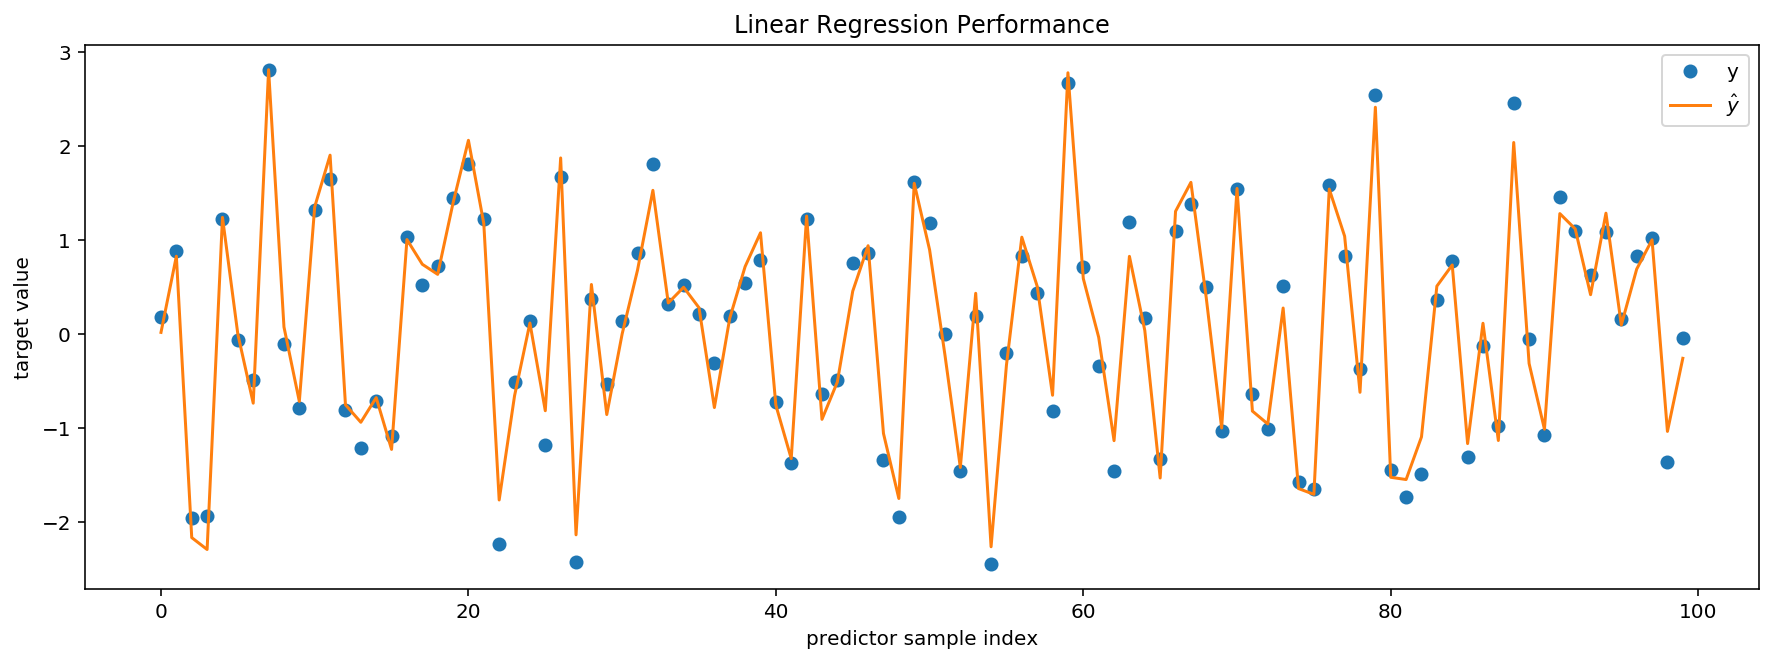

In [32]:
maxEpochs = 100

weights, lossPerEpoch = least_squares_grad_desc(predictors, targets,
                                                maxIter=maxEpochs, alpha=0.01,
                                                update='online',
                                                batch_size=10)
loss_SGD = lossPerEpoch

weights, lossPerEpoch = least_squares_grad_desc(predictors, targets,
                                                maxIter=maxEpochs, alpha=0.001,
                                                update='batch',
                                                batch_size=10)
loss_batch = lossPerEpoch

weights, lossPerEpoch = least_squares_grad_desc(predictors, targets,
                                                maxIter=maxEpochs, alpha=0.01,
                                                update='mini-batch',
                                                batch_size=10)
loss_miniBatch = lossPerEpoch

plot_regression_performance(predictor_indices, targets, regressed_targets)

(C) Make a graph of error on the entire data set as a function of epoch. An epoch is a complete sweep through all the data (which is one iteration for full-batch gradient descent).

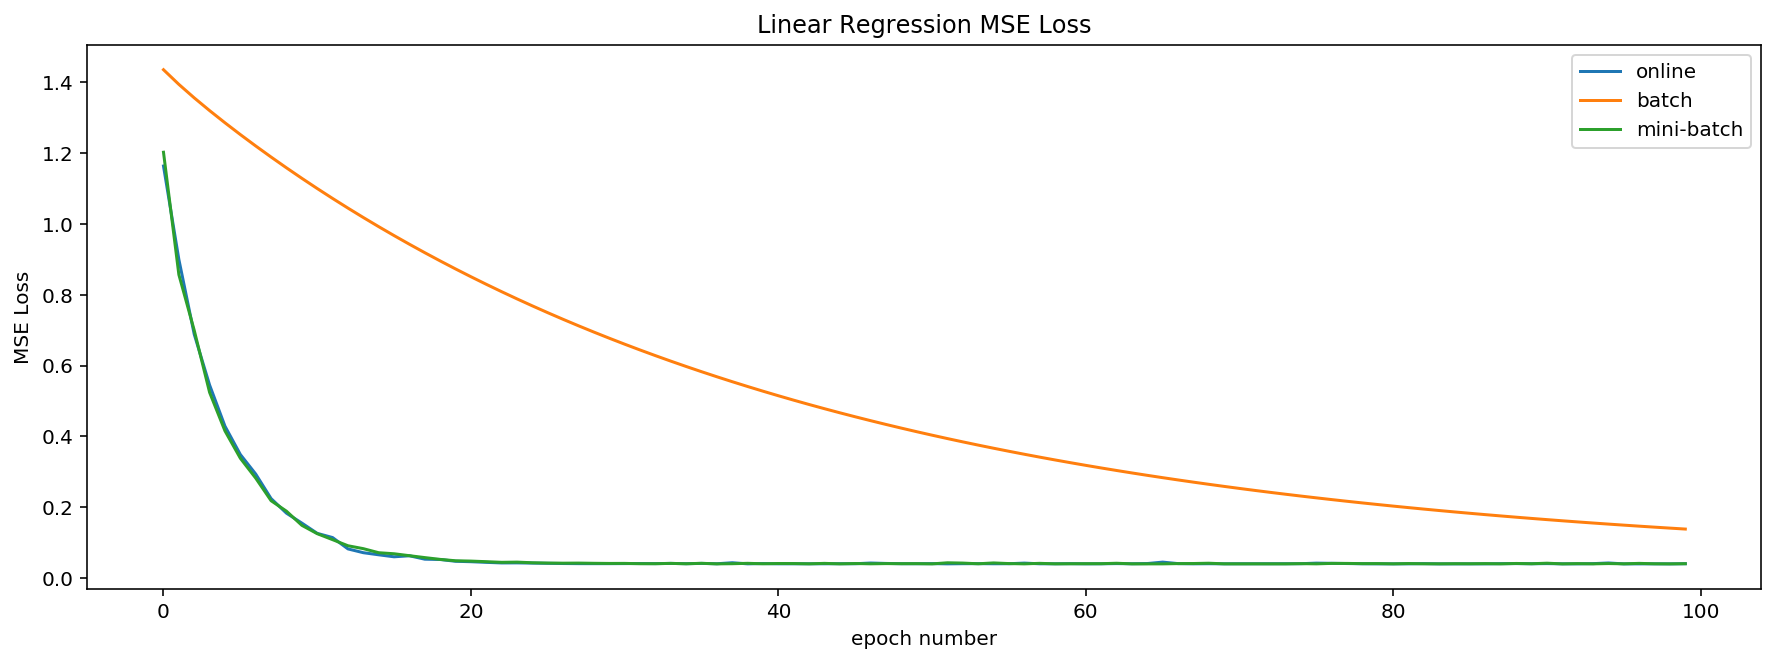

In [33]:
test_epoch_indices = range(0, len(lossPerEpoch))
plot_loss(test_epoch_indices, [loss_SGD, loss_batch, loss_miniBatch],
          xlabel='epoch number',
          ylabel='MSE Loss',
          legendStrings=('online', 'batch', 'mini-batch'))

## Part 3

The data set from a regression problem can be converted into a classification problem simply by using the sign of (+ or -) as representing one of two classes. In the data set used in Part 1 and 2, you'll see the variable z that represents this binary (0 or 1) class.

Use the perceptron learning rule to solve for the coefficients {$w_1$, $w_2$, $b$} of this classification problem.   

Two warnings: First, your solution to Part 3 should require only a few lines of code changed from the code you wrote for Part 2. Second, the Perceptron algorithm will not converge if there is no exact solution to the training data. It will jitter among coefficients that all yield roughly equally good solutions.

Complete the following functions below and use them to answer questions (A) and (B). 

**Note:** Please do not change the interface of the given functions.

In [57]:
def perceptron_update(X, y, w, alpha):
    """
    One epoch of Perceptron updates (full sweep of the dataset).
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    w : array of coefficients from the previous iteration
    alpha : Learning rate
    
    Returns
    -------
    w : Coefficients of the classifier (after updating)
    incorrect : Incorrectly classified examples
                (tuple of features, predicted label)
    accuracy: ratio of correctly classified to total examples
    """
    
    N = len(y)
    numberClassifiedRight = N
    incorrect = []
    
    for i in range(N):
        
        curr_x = X[i, :].reshape((-1, 1))
        curr_y = y[i]
        y_predicted = np.sign(w.T @ curr_x)
        
        # use perceptron update rule
        if curr_y != y_predicted:

            w += alpha * (curr_y * curr_x)

            numberClassifiedRight -= 1
            incorrect.append((curr_x, y_predicted))
        
    accuracy = numberClassifiedRight / N

    return w, incorrect, accuracy

def perceptron(X, y, maxIter, alpha):
    """
    Implements the Perceptron algorithm.
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    maxIter : The maximum number of iterations allowed 
    alpha : Learning Rate
    
    Returns
    -------
    w : Coefficients of the classifier
    incorrect : Incorrectly classified examples on termination
    accuracyPerEpoch : array-like of best accuracy each epoch
    """
    
    # define an accuracy tolerance as an additional termination condition
    accuracyRelTol = 1e-6
    accuracy = np.inf
    accuracyRelDiff = np.inf
    
    # as we want to learn the bias term as well, need to augment our feature
    # matrix
    X_b = getFeaturesWithBias(X)

    N = len(y)

    # initialize gradient descent with weights all being 0
    w = np.array([0.0, 0.0, 0.0]).reshape((3, 1))
    numEpochs = 0
    accuracyPerEpoch = []
    while (numEpochs < maxIter) and (accuracyRelDiff > accuracyRelTol):

        w, incorrect, newAccuracy = perceptron_update(X_b, y, w, alpha)

        accuracyRelDiff = np.abs(accuracy - newAccuracy)
        accuracy = newAccuracy
        accuracyPerEpoch.append(accuracy)
        
        # slow down printing of loss
        if (numEpochs % 1) == 0:
            print('Epoch: ', numEpochs, 'accuracy: ', accuracy)

        numEpochs += 1
    
    print('Max Epochs: ', numEpochs, 'Max Accuracy: ', accuracy)
        
    return w, incorrect, accuracyPerEpoch

(A) Report the values of coefficients $w_1$, $w_2$, and $b$.

In [70]:
# need negative classes to be -1
perceptron_labels = [-1 if label == 0 else 1 for label in target_class_labels]

(weights,
 incorrect,
 accuracyPerEpoch) = perceptron(predictors, perceptron_labels,
                                maxIter=100, alpha=1)

print('w_1:', weights[0])
print('w_2:', weights[1])
print('b:', weights[2])

Epoch:  0 accuracy:  0.76
Epoch:  1 accuracy:  0.86
Epoch:  2 accuracy:  0.91
Epoch:  3 accuracy:  0.9
Epoch:  4 accuracy:  0.89
Epoch:  5 accuracy:  0.92
Epoch:  6 accuracy:  0.9
Epoch:  7 accuracy:  0.9
Max Epochs:  8 Max Accuracy:  0.9
w_1: [-4.4264]
w_2: [7.1035]
b: [-2.]


$w_1 = -4.4264$ 

$w_2 = 7.1035$

$b = -2$

(B) Make a graph of the accuracy (% correct classification) on the training set as a function of epoch.

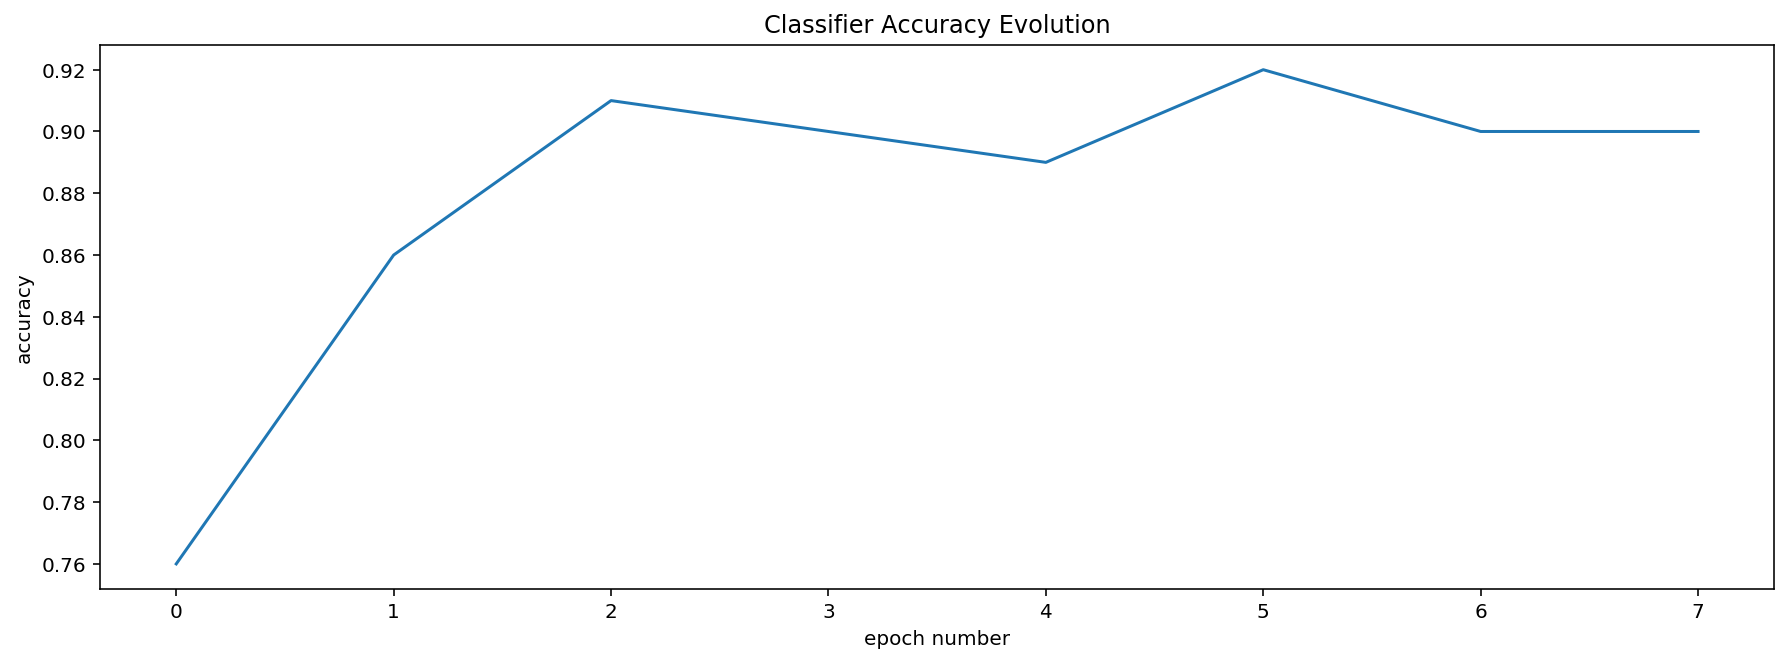

In [64]:
test_epoch_indices = range(0, len(accuracyPerEpoch))
plot_loss(test_epoch_indices, [accuracyPerEpoch],
          xlabel='epoch number',
          ylabel='accuracy',
          title='Classifier Accuracy Evolution')

## Part 4

In machine learning, we really want to train a model based on some data and then expect the model to do well on "out of sample" data. Try this with the code you wrote for Part 3:  Train the model on the first {5, 10, 25, 50, 75} examples in the data set and test the model on the final 25 examples.

Complete the following function below and use it to answer (A). 

**Note:** Please do not change the interface of the given function.

In [37]:
def classify(X, y, w):
    """
    Use this function to classify examples in the test set
    
    Parameters
    ----------
    X : Test set features
    y : Test set labels
    w : Perceptron coefficients
    
    Returns
    -------
    correct : number of correctly classified examples
    """
    pass

How does performance on the test set vary with the amount of training data? Make a bar graph showing performance for each of the different training set sizes.